# Final Implementation of ML Forecasting System

In this part of the project, we will first start by a general analysis of the emergency data. Later on, we will be fitting an ARIMA model to our data, using a time-series analysis to forecast the medical equipment's consumption

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
SEED = 7

Let's start by importing the medical equipment usages dataset gathered from several Lebanese Red Cross stations: 

In [59]:
#Read the data
df = pd.read_excel("Consumption_Data.xlsx")
#Type of variables
df.info()
#Remove Missing values
df = df.dropna(axis = 0, how = 'any')
#Sample of resulting dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1052 non-null   datetime64[ns]
 1   Day                 1052 non-null   object        
 2   Month               1052 non-null   object        
 3   Year                1052 non-null   int64         
 4   Season              1052 non-null   object        
 5   Nitrile Gloves      1052 non-null   int64         
 6   Medical Gown        1052 non-null   int64         
 7   Face Shield         1052 non-null   int64         
 8   N95 Mask            1052 non-null   int64         
 9   Compresse           1052 non-null   int64         
 10  Compressif Bandage  1052 non-null   int64         
 11  Glucometer Needles  1052 non-null   int64         
 12  Glucometer Strips   1052 non-null   int64         
 13  O2 Mask             1052 non-null   int64       

,Date,Day,Month,Year,Season,Nitrile Gloves,Medical Gown,Face Shield,N95 Mask,Compresse,Compressif Bandage,Glucometer Needles,Glucometer Strips,O2 Mask,Canulla,AED Patch,Serum Bag
0,2018-01-01,Monday,January,2018,Winter,61,31,31,30,1,2,4,1,2,0,0,0
1,2018-01-02,Tuesday,January,2018,Winter,58,28,29,28,2,2,4,3,3,1,1,0
2,2018-01-03,Wednesday,January,2018,Winter,63,31,31,32,1,1,4,1,3,0,0,0
3,2018-01-04,Thursday,January,2018,Winter,58,28,30,30,2,1,2,3,2,0,0,0
4,2018-01-05,Friday,January,2018,Winter,52,25,27,26,1,2,4,3,3,0,0,0


## Equipment Usage Dataset

This dataset includes the daily consumption of different medical equipment across one Red Cross station.

The collected data contains these features:

*   Date: the date
*   Day: the day of the week
*   Month: the month od the year
*   Year: the specific year
*   Season: the season of the year
*   Nitrile Gloves: the consumption of nitrile gloves for a day
*   Medical Gown: the consumption of medical gowns for a day
*   Face Shield: the consumption of face shields for a day
*   N95: the consumption of N95 masks for a day
*   Compresse: the consumption of compresses masks for a day
*   Compressif Bandage: the consumption of compressive bandages for a day
*   Glucometer Needles: the consumption of glucometer needles for a day
*   Glucometer Strips: the consumption of glucometer strips for a day
*   O2 Mask: the consumption of O2 masks for a day
*   Canulla: the consumption of canullas for a day
*   AED Patch: the consumption of defibrillator patches for a day
*   Serum Bag: the consumption of serum bags for a day

For our specific use, we will then consider the Date, Day, Month, Year, Season to be the feature variables, and the labels (or predictions to be made) to be the medical equipment.

## EDA

Let's proceed by visualizing, understanding and analyzing the data.

Visualizing the average consumption of each equipment:

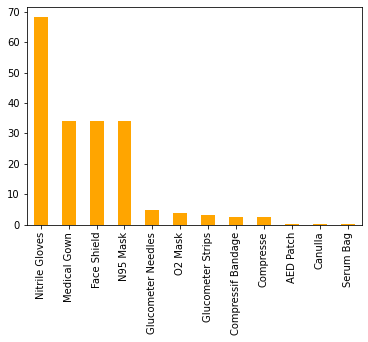

In [60]:
consumption = df.drop(['Date', 'Day', 'Month', 'Year'], axis = 1)
average_consumption = consumption.mean()

average_consumption.sort_values(ascending=False).plot.bar(color = 'orange')

Averaging over all consumption, the data is self explanatory.


It seems like the number of nitrile gloves is double the number of face shields, medical gowns and N95s, explainable by the fact that a rescuer wears two gloves for every one of these items.
Also, the consumption of other items is very low in comparaison with the PPEs, which are used in every emergency.

Let's now visualize the correlation between the features:

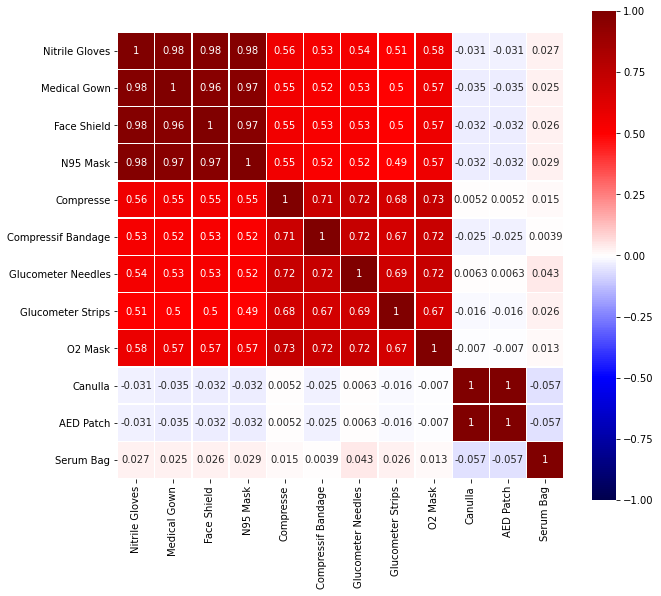

In [61]:
#The date is identified by the other feautures: we will drop it:
data = df.drop(['Date'], axis = 1)
color = plt.get_cmap('RdYlGn')   # default color
color.set_bad('lightblue')
plt.figure(figsize=(10,9))
sns.heatmap(data.drop(['Year'], axis = 1).corr(), cmap='seismic', vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5);

Verifying our explanation, there seem to be high correlation between nitrile gloves, medical gowns, face shields and N95 maks. We can also verify the correlation between canullas and AED patches: they are both always used in a CPR emergency.

## ARIMA
*Prepare the data for ARIMA: we have to design a plot for every medical equipment. For that, we will be using a 20-day moving average*

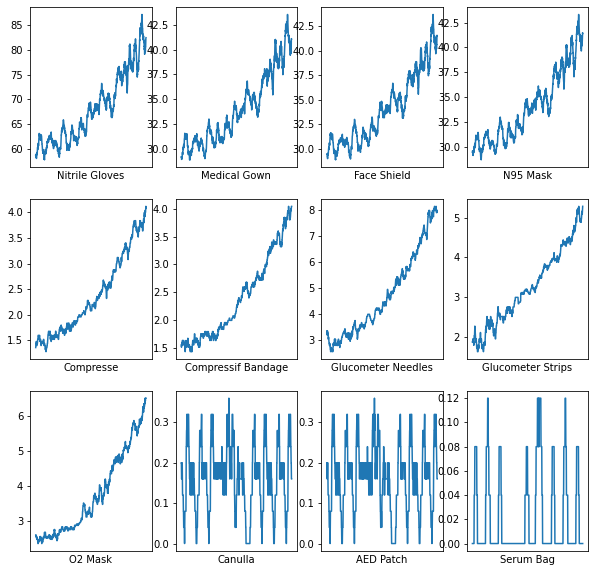

In [62]:
df.Date = pd.to_datetime(df.Date)

class_labels = ['Nitrile Gloves', 'Medical Gown', 'Face Shield', 'N95 Mask',
                'Compresse', 'Compressif Bandage', 'Glucometer Needles',
                'Glucometer Strips', 'O2 Mask', 'Canulla', 'AED Patch', 'Serum Bag']

Nitrile_Gloves = df[['Date', 'Nitrile Gloves']]
Gowns = df[['Date', 'Medical Gown']]
Face_Shields = df[['Date', 'Face Shield']]
N95 = df[['Date', 'N95 Mask']]
Compresse = df[['Date', 'Compresse']]
Compressif_Band = df[['Date', 'Compressif Bandage']]
Needle = df[['Date', 'Glucometer Needles']]
Strips = df[['Date', 'Glucometer Strips']]
O2 = df[['Date', 'O2 Mask']]
Canulla = df[['Date', 'Canulla']]
AED_Patch = df[['Date', 'AED Patch']]
Serum = df[['Date', 'Serum Bag']]

#Moving Averages
Moving_Average = 25

Rolling_Averages = {'Nitrile Gloves' : Nitrile_Gloves['Nitrile Gloves'].rolling(window = Moving_Average).mean(), 
                    'Medical Gown' : Gowns['Medical Gown'].rolling(window = Moving_Average).mean(), 
                    'Face Shield' : Face_Shields['Face Shield'].rolling(window = Moving_Average).mean(),
                    'N95 Mask' : N95['N95 Mask'].rolling(window = Moving_Average).mean(),
                    'Compresse' : Compresse['Compresse'].rolling(window = Moving_Average).mean(),
                    'Compressif Bandage' : Compressif_Band['Compressif Bandage'].rolling(window = Moving_Average).mean(),
                    'Glucometer Needles' : Needle['Glucometer Needles'].rolling(window = Moving_Average).mean(),
                    'Glucometer Strips' : Strips['Glucometer Strips'].rolling(window = Moving_Average).mean(),
                    'O2 Mask' : O2['O2 Mask'].rolling(window = Moving_Average).mean(),
                    'Canulla' : Canulla['Canulla'].rolling(window = Moving_Average).mean(),
                    'AED Patch' : AED_Patch['AED Patch'].rolling(window = Moving_Average).mean(),
                    'Serum Bag' : Serum['Serum Bag'].rolling(window = Moving_Average).mean()}


plt.figure(figsize=(10,10))
for i in range(len(class_labels)):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.plot(df.Date ,Rolling_Averages[class_labels[i]])
    plt.xlabel(class_labels[i])
plt.show()

### Analysis of Time-Series Plots
The plots above show the consumption of several medical equipment with regards to time, from the start of 2018 to the end of 2020.


Different insights can be drawn:


*   The consumption of gloves, gowns, masks, compresse, compressif bandages, needles and strips is clearly increasing with time, with a spike at the middle (at the start of 2020), in correlation with the start of the COVID-19 pandemic. This can be explained by the fact that the number emergencies dispatched to the station has increased with time, and the need of PPE has also increased accordingly.
*   In regards to the canullas, AED patches and serum bags, the number is constantly oscillating within a small range [0,1] without any correlation with time. This can be explained by the fact that the number emergencies necessitating such equipment (mainly CPR emergencies) has stayed the same, even with COVID-19 on the rise.

Moreover, not only do the plots indivually give us insight, but by compating them together we can also understand the behavior of the station. Verifying our previous assumptions, the slopes of the curves are pretty much the same accross all the protective equipment, proving a correlation between the increases of the studied material.



### Testing for stationarity
We can notice in the graphs above that it's possible to find a trend where there is a time when consumption is high and vice versa. That means we can see data is following seasonality. For ARIMA first thing we need to do is identify if the data is stationary or non – stationary. If the data is non-stationary, we will try to make it stationary before proceeding

In [63]:
from statsmodels.tsa.stattools import adfuller

#We define the below function, computing the probabilities of two hypothesis to check for stationarity
#We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary \n ")

for i in class_labels:
  print("For " + i + ":")
  adfuller_test(Rolling_Averages[i].dropna())
  Rolling_Averages[i] = Rolling_Averages[i].iloc[24:]
  Rolling_Averages[i] = Rolling_Averages[i].reset_index(drop = True)
df.Date = df.Date.iloc[24:]


df.Date = df.Date.reset_index(drop = True)


For Nitrile Gloves:
ADF Test Statistic : -0.943876141506048
p-value : 0.773180337895845
#Lags Used : 7
Number of Observations : 1020
weak evidence against null hypothesis,indicating it is non-stationary 
 
For Medical Gown:
ADF Test Statistic : -0.8773204381837438
p-value : 0.795349352225669
#Lags Used : 6
Number of Observations : 1021
weak evidence against null hypothesis,indicating it is non-stationary 
 
For Face Shield:
ADF Test Statistic : -0.6171299066013288
p-value : 0.8670642020713077
#Lags Used : 21
Number of Observations : 1006
weak evidence against null hypothesis,indicating it is non-stationary 
 
For N95 Mask:
ADF Test Statistic : -0.8041872394605063
p-value : 0.8178890023056808
#Lags Used : 19
Number of Observations : 1008
weak evidence against null hypothesis,indicating it is non-stationary 
 
For Compresse:
ADF Test Statistic : 1.0224581839708355
p-value : 0.9944973464134167
#Lags Used : 5
Number of Observations : 1022
weak evidence against null hypothesis,indicating it

As can be seen above, gloves, gowns, masks, compresse, compressif bandages, needles and strips are all non stationary

### Transorming the time series
In this section, we will transform the time series studied above to make them stationary, and then conduct a verification according to the adfuller test defined above.

In [64]:
# create a differenced series to make series stationnary
def difference(dataset, interval=1):
	diff = list()
	for i in range(25, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

Stationary_Series = {}

for i in class_labels:
  Stationary_Series[i] = difference(Rolling_Averages[i])
  print("For " + i + ":")
  adfuller_test(Stationary_Series[i])
  print("\n")



For Nitrile Gloves:
ADF Test Statistic : -5.874081795818018
p-value : 3.1897262533266933e-07
#Lags Used : 22
Number of Observations : 980
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


For Medical Gown:
ADF Test Statistic : -5.8572175491484595
p-value : 3.477295103622278e-07
#Lags Used : 22
Number of Observations : 980
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


For Face Shield:
ADF Test Statistic : -5.773447283935285
p-value : 5.326299305041625e-07
#Lags Used : 22
Number of Observations : 980
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


For N95 Mask:
ADF Test Statistic : -5.742492781838127
p-value : 6.228914090917813e-07
#Lags Used : 22
Number of Observations : 980
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


For Compresse:
ADF Test Statistic : -14.950130643758248
p-value : 1.2

After applying Differencing to the datasets, a method of transforming a time series dataset to remove the series dependence on time, so-called temporal dependence such as trends and seasonality, they are now all stationary according to the adfuller test.

### Defining the ARIMA model

For the purpose of this dataset, after making our data stationary, we will use the Holt ARIMA model to account for the increasing trend observed in the above graphs.
The graphs will be showing the fits of the Holt model on the available dates, and the forecasts for the two weeks to come.

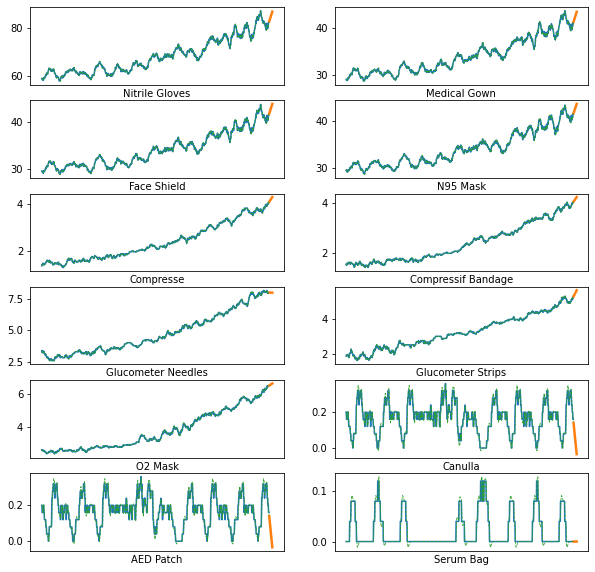

In [87]:
from statsmodels.tsa.api import Holt

Models = {}
Forecasts = {}
Fitted_Values = {}

for i in class_labels:
  Models[i] = Holt(Rolling_Averages[i]).fit(smoothing_level = 0.5, smoothing_slope = 0.2, optimized = True)
  Forecasts[i] =  Models[i].forecast(15)
  Fitted_Values[i] = Models[i].fittedvalues

plt.figure(figsize=(10,10))
for i in range(len(class_labels)):
    plt.subplot(6,2,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.plot(Rolling_Averages[class_labels[i]])
    plt.plot(Forecasts[class_labels[i]], linewidth = 2.5)
    Fitted_Values[class_labels[i]].plot(style = '--', linewidth = 0.8)
    plt.xlabel(class_labels[i])
plt.show()

Shown on the graphs above are plots of:


*   The actual consumption (in blue)
*   Our fitted model (in green)
*   The forecast for the next two weeks (in orange)

It's clear that the blue and green curves are overlapping on all graphs, showing a minimal training error for our Holt model.



### Forecasting: Finalizing Initial Implementation
Let's run some code to predict the consumption for the two weeks to come, and come up with a recommendation for an order:

Defining the function to be used first:

In [88]:
def order(days):
  Forecast = {}
  for i in class_labels:
    Forecast[i] = Models[i].forecast(days).sum().round()
  return Forecast


### Testing the forecast for the next two weeks


In [89]:
import pprint
pprint.pprint(order(14))

{'AED Patch': 1.0,
 'Canulla': 1.0,
 'Compresse': 59.0,
 'Compressif Bandage': 58.0,
 'Face Shield': 597.0,
 'Glucometer Needles': 112.0,
 'Glucometer Strips': 76.0,
 'Medical Gown': 591.0,
 'N95 Mask': 595.0,
 'Nitrile Gloves': 1185.0,
 'O2 Mask': 92.0,
 'Serum Bag': 0.0}
